In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from astropy.modeling.models import Linear1D, Exponential1D
import numpy as np
from astropy.table import vstack, Table
import pickle
import os

## Validation of galaxy distribution
This notebook compare galaxy distribution from slsim with DC2 and Diffsky galaxy

distribution in a 1 degree square sky area. To run this notebook, one need to 

download dc2 and diffsky galaxy catalog from following link: https://github.com/LSST-strong-lensing/data_public.

Please replace dc2 and diffsky paths in cell 8.

## Define a cosmology and sky area

In [2]:
# define a cosmology
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=1, unit="deg2")

## Plot Schechter functions

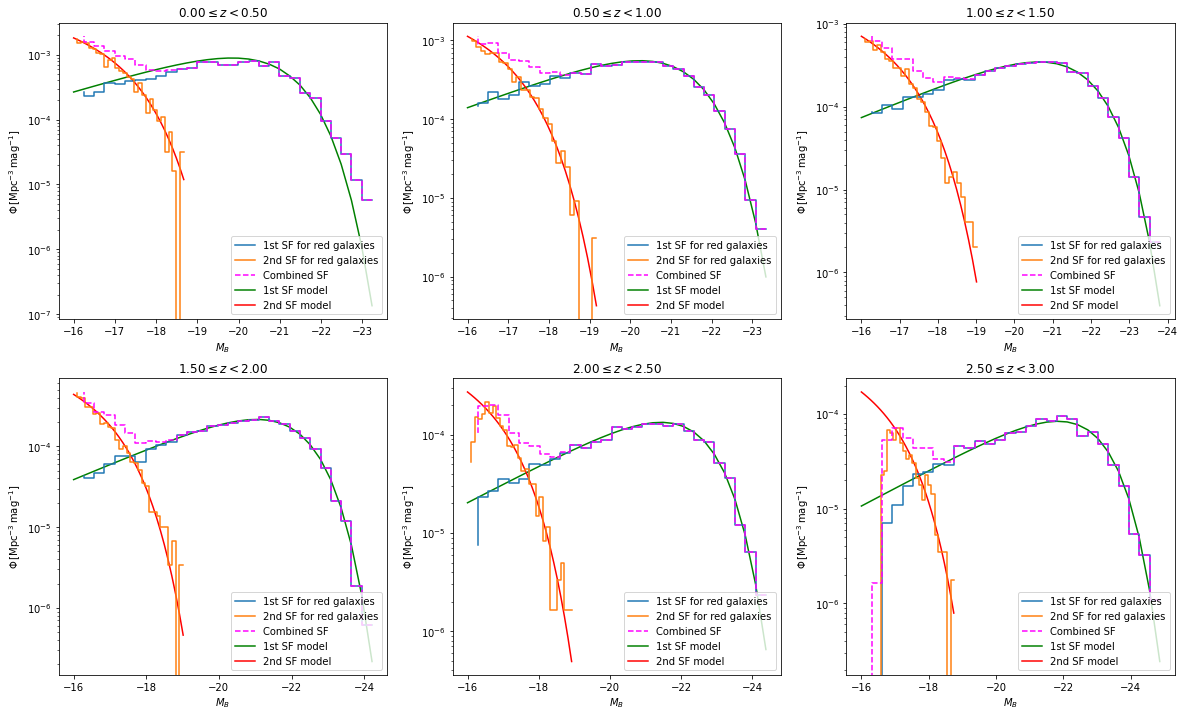

In [3]:
m_star = Linear1D(-0.80, -20.46)
phi_star = Exponential1D(0.00278612, -1.05925)
alpha = -0.53
m_star2 = -17
alpha2 = -1.31
path = os.getcwd()
new_path = path.replace("notebooks/validation_notebooks", 'tests/TestData/') 
pipeline_1 = SkyPyPipeline(
    skypy_config=new_path+"lsst_like_test_1.yml", sky_area=sky_area, filters=None, cosmo=cosmology
)
red_galaxies_1 = pipeline_1.red_galaxies
redshift, magnitude = red_galaxies_1["z"], red_galaxies_1["M"]
# 2nd schechter function
pipeline_2 = SkyPyPipeline(
    skypy_config=new_path+"lsst_like_test_2.yml", sky_area=sky_area, filters=None, cosmo=cosmology
)
red_galaxies_2 = pipeline_2.red_galaxies
redshift2, magnitude2 = red_galaxies_2["z"], red_galaxies_2["M"]

# combined schechterfunction
redshift3 = np.concatenate((redshift, redshift2))
magnitude3 = np.concatenate((magnitude, magnitude2))


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(20, 12)
)
bins = np.linspace(-24.84408295574346, -14, 40)
bins2 = np.linspace(-19.1724664526037, -14, 30)
z_slices = ((0.0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3))

for ax, (z_min, z_max) in zip([ax1, ax2, ax3, ax4, ax5, ax6], z_slices):

    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    magnitude_bin = magnitude[z_mask]
    bins = np.linspace(min(magnitude_bin), -16, 30)
    dV_dz = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV = np.trapz(dV_dz, z)
    dM = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
    phi_first_red = np.histogram(magnitude[z_mask], bins=bins)[0] / dV / dM

    z_mask2 = np.logical_and(redshift2 >= z_min, redshift2 < z_max)
    magnitude_bin2 = magnitude2[z_mask2]
    bins2 = np.linspace(min(magnitude_bin2), -16, 30)
    dV_dz2 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV2 = np.trapz(dV_dz2, z)
    dM2 = (np.max(bins2) - np.min(bins2)) / (np.size(bins2) - 1)
    phi_second_red = np.histogram(magnitude2[z_mask2], bins=bins2)[0] / dV2 / dM2

    z_mask3 = np.logical_and(redshift3 >= z_min, redshift3 < z_max)
    dV_dz3 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV3 = np.trapz(dV_dz3, z)
    dM3 = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
    phi_combined_red = np.histogram(magnitude3[z_mask3], bins=bins)[0] / dV3 / dM3

    # Median-redshift Schechter function
    L = 10 ** (0.4 * (m_star(z) - bins[:, np.newaxis]))
    phi_model_z = 0.4 * np.log(10) * phi_star(z) * L ** (alpha + 1) * np.exp(-L)
    phi_model = np.median(phi_model_z, axis=1)

    L2 = 10 ** (0.4 * (m_star2 - bins2[:, np.newaxis]))
    phi_model_z2 = 0.4 * np.log(10) * phi_star(z) * L2 ** (alpha2 + 1) * np.exp(-L2)
    phi_model2 = np.median(phi_model_z2, axis=1)

    # Plotting
    ax.step(
        bins[:-1],
        phi_first_red,
        where="post",
        label="1st SF for red galaxies",
        zorder=3,
    )
    ax.step(
        bins2[:-1],
        phi_second_red,
        where="post",
        label="2nd SF for red galaxies",
        zorder=3,
    )
    ax.step(
        bins[:-1],
        phi_combined_red,
        where="post",
        ls="--",
        label="Combined SF",
        color="magenta",
        zorder=3,
    )
    ax.plot(bins, phi_model, label="1st SF model", color="g")
    ax.plot(bins2, phi_model2, label="2nd SF model", color="red")
    ax.set_title(r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max))
    ax.set_xlabel(r"$M_B$")
    ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$")
    ax.set_yscale("log")
    # ax.set_xlim([-14, -24])
    # ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="lower right")
    ax.invert_xaxis()
plt.show()

## Get galaxy distribution from SkyPyPipeline

In [25]:
## For the red galaxies, this configuration uses combined Schechter
# function (magenta curve in above plot).
pipeline_double = SkyPyPipeline(sky_area=sky_area, filters=None, cosmo=cosmology)
## For the red galaxies, this configuration uses single Schechter
# function (blue curve in above plot).
pipeline_single = SkyPyPipeline(
    skypy_config="lsst_like_old", sky_area=sky_area, filters=None, cosmo=cosmology
)

In [26]:
## Let's draw red galaxies from these two different Schechter function.
red_galaxies_double = pipeline_double.red_galaxies
red_galaxies_single = pipeline_single.red_galaxies

In [27]:
# These are all galaxies from from two cases.
single_total = vstack([pipeline_single.red_galaxies, pipeline_single.blue_galaxies])
single_total = single_total[(single_total["z"] < 3.01) & (single_total["mag_i"] < 30)]
double_total = vstack([pipeline_double.red_galaxies, pipeline_double.blue_galaxies])
double_total = double_total[(double_total["z"] < 3.01) & (double_total["mag_i"] < 30)]

## Comparision of red galaxy distribution with 
## single and double Schechter function.

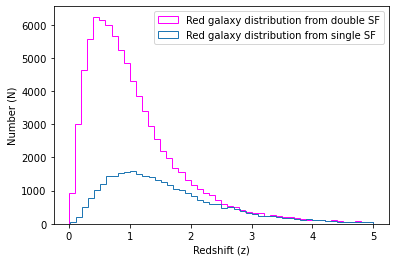

In [28]:
## Plot red galaxy distributions from single Schechter function and double Schcheter
# functions.
plt.hist(
    red_galaxies_double["z"],
    bins=50,
    histtype="step",
    label="Red galaxy distribution from double SF",
    color="magenta",
)
plt.hist(
    red_galaxies_single["z"],
    bins=50,
    histtype="step",
    label="Red galaxy distribution from single SF",
)
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend()

## Load DC2 and Diffsky galaxy catalog
These catalogs are from 1 degree square sky area.

In [29]:
with open("/Users/narayankhadka/downloads/dc2_galaxy2_catalog_1deg2.txt", "rb") as file:
    # Use pickle.load() to load the data from the file
    dc2_galaxies = pickle.load(file)

with open("/Users/narayankhadka/downloads/dc2_galaxy1_catalog_1deg2.txt", "rb") as file:
    # Use pickle.load() to load the data from the file
    dc2_galaxies2 = pickle.load(file)

with open(
    "/Users/narayankhadka/downloads/diffsky_galaxy_catalog_1deg2.txt", "rb"
) as file:
    # Use pickle.load() to load the data from the file
    diffsky_galaxies = pickle.load(file)
with open(
    "/Users/narayankhadka/downloads/diffsky_galaxy2_catalog_1deg2.txt", "rb"
) as file:
    # Use pickle.load() to load the data from the file
    diffsky_galaxies2 = pickle.load(file)

In [30]:
dc2_galaxies = Table(dc2_galaxies)
dc2_galaxies = dc2_galaxies[dc2_galaxies["mag_true_i_lsst"] < 30]
dc2_galaxies2 = Table(dc2_galaxies2)
dc2_galaxies2 = dc2_galaxies2[dc2_galaxies2["mag_true_i_lsst"] < 30]
diffsky_galaxies = Table(diffsky_galaxies)
diffsky_galaxies = diffsky_galaxies[diffsky_galaxies["mag_true_i_lsst"] < 30]
diffsky_galaxies2 = Table(diffsky_galaxies2)
diffsky_galaxies2 = diffsky_galaxies2[diffsky_galaxies2["mag_true_i_lsst"] < 30]

In [31]:
print(
    min(diffsky_galaxies["redshift"]),
    max(diffsky_galaxies["redshift"]),
    min(diffsky_galaxies["mag_true_i_lsst"]),
    max(diffsky_galaxies["mag_true_i_lsst"]),
)

0.015004985975324292 3.0784268934021073 14.266190839010237 29.999986591958766


In [32]:
print(
    min(dc2_galaxies["redshift"]),
    max(dc2_galaxies["redshift"]),
    min(dc2_galaxies["mag_true_i_lsst"]),
    max(dc2_galaxies["mag_true_i_lsst"]),
)
print(
    min(double_total["z"]),
    max(double_total["z"]),
    min(double_total["mag_i"]),
    max(double_total["mag_i"]),
)

0.012666132057165269 3.0940996130362075 13.834526 29.999998
0.0004640712279099357 3.0099955391950304 13.959508995650118 29.999993209676237


## Comparision of total galaxy distribution

Text(0.5, 1.0, '$mag_i < 30$')

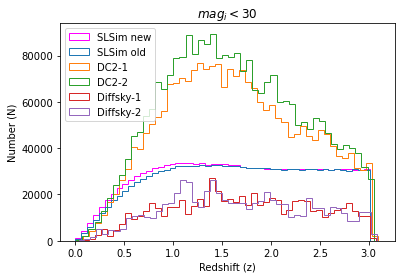

In [33]:
m_min = 0
m_max = 60
plt.hist(
    double_total[(double_total["mag_i"] > m_min) & (double_total["mag_i"] < m_max)][
        "z"
    ],
    bins=50,
    density=False,
    histtype="step",
    label="SLSim new",
    color="magenta",
    cumulative=False,
)
plt.hist(
    single_total[(single_total["mag_i"] > m_min) & (single_total["mag_i"] < m_max)][
        "z"
    ],
    bins=50,
    density=False,
    histtype="step",
    label="SLSim old",
    cumulative=False,
)
plt.hist(
    dc2_galaxies[
        (dc2_galaxies["mag_true_i_lsst"] > m_min)
        & (dc2_galaxies["mag_true_i_lsst"] < m_max)
    ]["redshift"],
    bins=50,
    density=False,
    histtype="step",
    label="DC2-1",
    cumulative=False,
)
plt.hist(
    dc2_galaxies2[
        (dc2_galaxies2["mag_true_i_lsst"] > m_min)
        & (dc2_galaxies2["mag_true_i_lsst"] < m_max)
    ]["redshift"],
    bins=50,
    density=False,
    histtype="step",
    label="DC2-2",
    cumulative=False,
)
plt.hist(
    diffsky_galaxies[
        (diffsky_galaxies["mag_true_i_lsst"] > m_min)
        & (diffsky_galaxies["mag_true_i_lsst"] < m_max)
    ]["redshift"],
    bins=50,
    density=False,
    histtype="step",
    label="Diffsky-1",
    cumulative=False,
)
plt.hist(
    diffsky_galaxies2[
        (diffsky_galaxies2["mag_true_i_lsst"] > m_min)
        & (diffsky_galaxies2["mag_true_i_lsst"] < m_max)
    ]["redshift"],
    bins=50,
    density=False,
    histtype="step",
    label="Diffsky-2",
    cumulative=False,
)
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend(loc="upper left", fontsize=10)
plt.title(r"$mag_i < 30$")

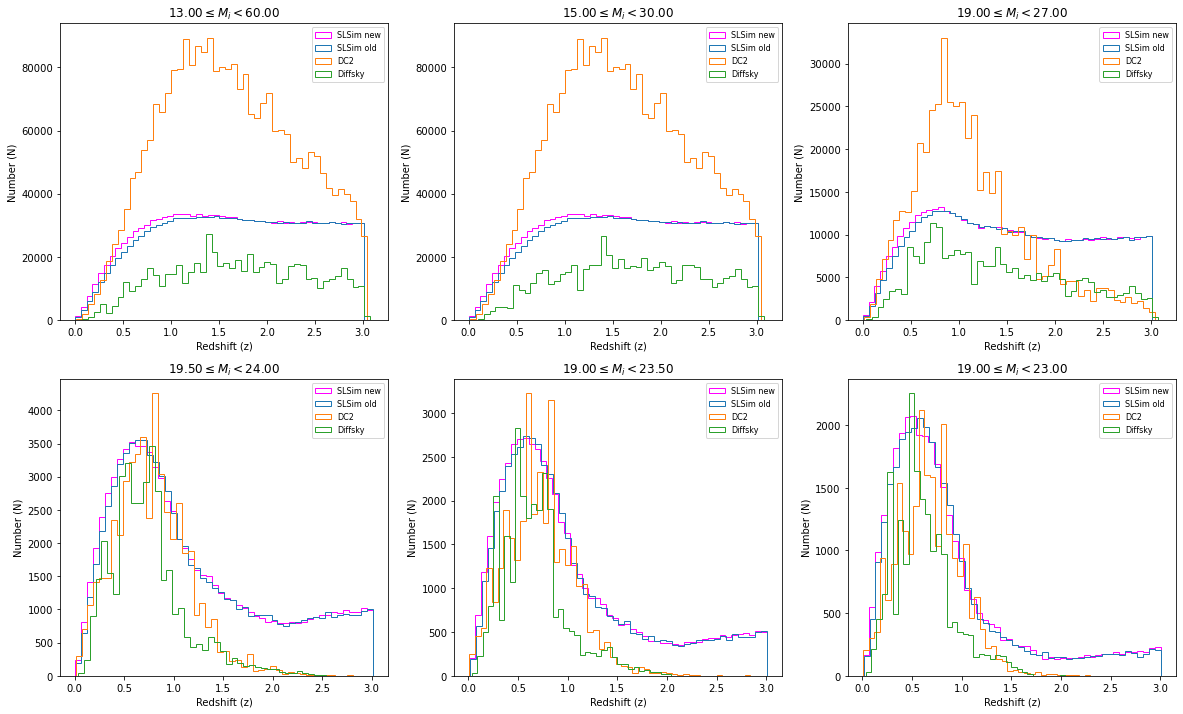

In [34]:
# m_min = 0
# m_max = 60
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(20, 12)
)
m_slices = ((13, 60), (15, 30), (19, 27), (19.5, 24), (19, 23.5), (19, 23))

for ax, (m_min, m_max) in zip([ax1, ax2, ax3, ax4, ax5, ax6], m_slices):
    ax.hist(
        double_total[(double_total["mag_i"] > m_min) & (double_total["mag_i"] < m_max)][
            "z"
        ],
        bins=50,
        density=False,
        histtype="step",
        label="SLSim new",
        color="magenta",
        cumulative=False,
    )
    ax.hist(
        single_total[(single_total["mag_i"] > m_min) & (single_total["mag_i"] < m_max)][
            "z"
        ],
        bins=50,
        density=False,
        histtype="step",
        label="SLSim old",
        cumulative=False,
    )
    """ax.hist(dc2_galaxies[(dc2_galaxies["mag_true_i_lsst"]>m_min) & 
                           (dc2_galaxies["mag_true_i_lsst"]<m_max)]["redshift"], 
                           bins=50, density=False, histtype="step",
                  label="DC2-1", cumulative=False)"""
    ax.hist(
        dc2_galaxies2[
            (dc2_galaxies2["mag_true_i_lsst"] > m_min)
            & (dc2_galaxies2["mag_true_i_lsst"] < m_max)
        ]["redshift"],
        bins=50,
        density=False,
        histtype="step",
        label="DC2",
        cumulative=False,
    )
    ax.hist(
        diffsky_galaxies[
            (diffsky_galaxies["mag_true_i_lsst"] > m_min)
            & (diffsky_galaxies["mag_true_i_lsst"] < m_max)
        ]["redshift"],
        bins=50,
        density=False,
        histtype="step",
        label="Diffsky",
        cumulative=False,
    )
    """ax.hist(diffsky_galaxies2[(diffsky_galaxies2["mag_true_i_lsst"]>m_min) & 
                                 (diffsky_galaxies2["mag_true_i_lsst"]<m_max)]["redshift"], 
               bins=50, density=False, histtype="step",
                  label="Diffsky-2", cumulative=False)"""
    ax.set_xlabel("Redshift (z)")
    ax.set_ylabel("Number (N)")
    ax.legend(fontsize=8)
    ax.set_title(r"${:.2f} \leq M_i < {:.2f}$".format(m_min, m_max))

## Comparision of SLSim, SC2, and Diffsky galaxy 
## luminosity functions

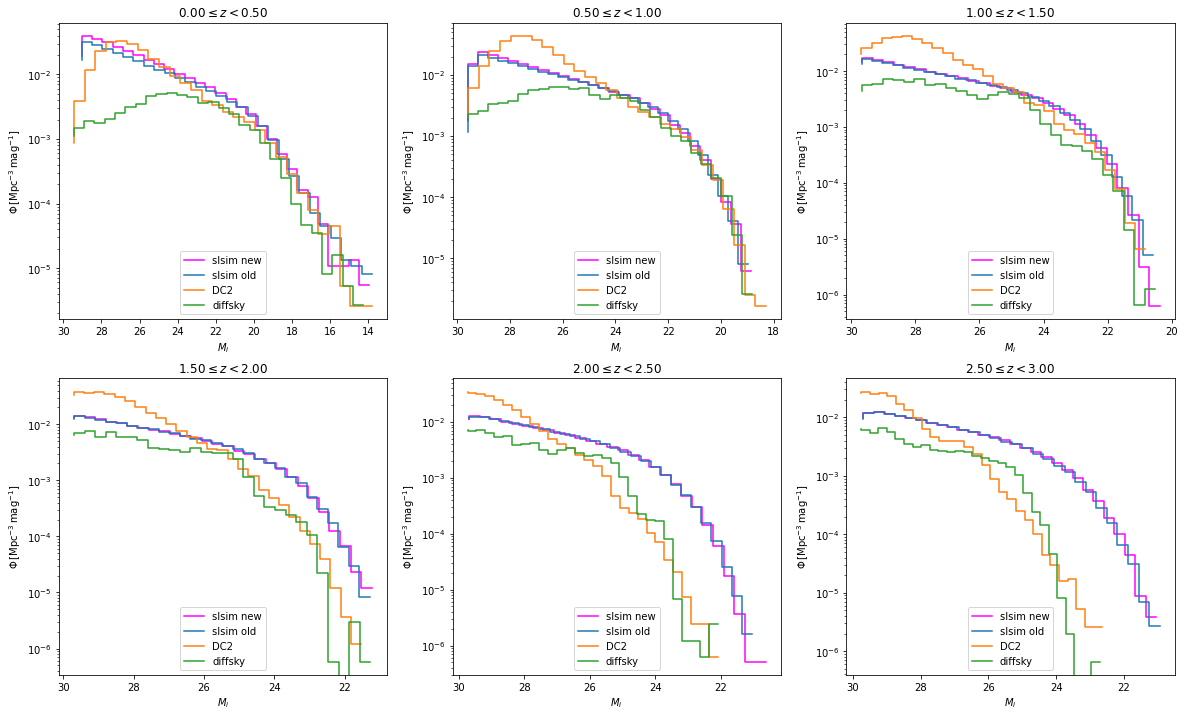

In [35]:
z_range = np.linspace(0.0, 3.01, 100)
## These are the parameters used in the lsst-like_new.yml file for 1st schechter
# function for red galaxies.
# slsim new
redshift, magnitude = double_total["z"], double_total["mag_i"]

# slsim old
redshift2, magnitude2 = single_total["z"], single_total["mag_i"]


# dc2
redshift3, magnitude3 = dc2_galaxies["redshift"], dc2_galaxies["mag_true_i_lsst"]

# diffsky
redshift4, magnitude4 = (
    diffsky_galaxies["redshift"],
    diffsky_galaxies["mag_true_i_lsst"],
)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(20, 12)
)
# bins = np.linspace(-24.84408295574346, -14, 40)
# bins2 = np.linspace(-19.1724664526037, -14, 30)
z_slices = ((0.0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3))

for ax, (z_min, z_max) in zip([ax1, ax2, ax3, ax4, ax5, ax6], z_slices):

    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    magnitude_bin = magnitude[z_mask]
    bins = np.linspace(min(magnitude_bin), max(magnitude_bin), 30)
    dV_dz = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV = np.trapz(dV_dz, z)
    dM = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
    phi_slsim_new = np.histogram(magnitude[z_mask], bins=bins)[0] / dV / dM

    z_mask2 = np.logical_and(redshift2 >= z_min, redshift2 < z_max)
    magnitude_bin2 = magnitude2[z_mask2]
    bins2 = np.linspace(min(magnitude_bin2), max(magnitude_bin2), 30)
    dV_dz2 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV2 = np.trapz(dV_dz2, z)
    dM2 = (np.max(bins2) - np.min(bins2)) / (np.size(bins2) - 1)
    phi_slsim_old = np.histogram(magnitude2[z_mask2], bins=bins2)[0] / dV2 / dM2

    z_mask3 = np.logical_and(redshift3 >= z_min, redshift3 < z_max)
    magnitude_bin3 = magnitude3[z_mask3]
    bins3 = np.linspace(min(magnitude_bin3), max(magnitude_bin3), 30)
    dV_dz3 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV3 = np.trapz(dV_dz3, z)
    dM3 = (np.max(bins3) - np.min(bins3)) / (np.size(bins3) - 1)
    phi_dc2 = np.histogram(magnitude3[z_mask3], bins=bins3)[0] / dV3 / dM3

    z_mask4 = np.logical_and(redshift4 >= z_min, redshift4 < z_max)
    magnitude_bin4 = magnitude4[z_mask4]
    bins4 = np.linspace(min(magnitude_bin4), max(magnitude_bin4), 30)
    dV_dz4 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV4 = np.trapz(dV_dz4, z)
    dM4 = (np.max(bins4) - np.min(bins4)) / (np.size(bins4) - 1)
    phi_diffsky = np.histogram(magnitude4[z_mask4], bins=bins4)[0] / dV4 / dM4

    # Plotting
    ax.step(
        bins[:-1],
        phi_slsim_new,
        where="post",
        label="slsim new",
        color="magenta",
        zorder=3,
    )
    ax.step(bins2[:-1], phi_slsim_old, where="post", label="slsim old", zorder=3)
    ax.step(bins3[:-1], phi_dc2, where="post", label="DC2", zorder=3)
    ax.step(bins4[:-1], phi_diffsky, where="post", label="diffsky", zorder=3)
    ax.set_title(r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max))
    ax.set_xlabel(r"$M_i$")
    ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$")
    ax.set_yscale("log")
    # ax.set_xlim([-14, -24])
    # ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="lower center")
    ax.invert_xaxis()
plt.show()

## SLSim galaxy luminosity functions in different 
## redshift bins. 

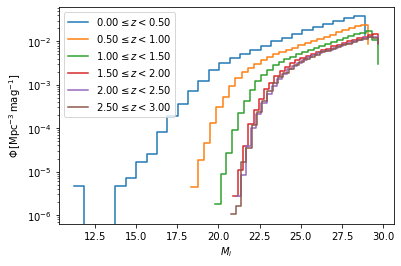

In [16]:
fig, ax = plt.subplots()
for z_min, z_max in z_slices:
    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    magnitude_bin = magnitude[z_mask]
    bins = np.linspace(min(magnitude_bin), max(magnitude_bin), 30)
    dV_dz = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV = np.trapz(dV_dz, z)
    dM = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
    phi_slsim_new = np.histogram(magnitude[z_mask], bins=bins)[0] / dV / dM

    # Plotting
    ax.step(
        bins[:-1],
        phi_slsim_new,
        where="post",
        label=r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max),
        zorder=3,
    )
    ax.set_xlabel(r"$M_i$")
    ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$")
    ax.set_yscale("log")
    # ax.set_xlim([-14, -24])
    # ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="upper left")
    # Invert the x-axis
# plt.show()

## Diffsky galaxy luminosity functions in different 
## redshift bins. 

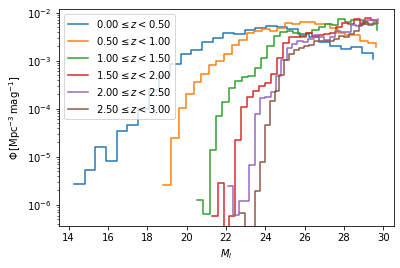

In [19]:
fig, ax = plt.subplots()
for z_min, z_max in z_slices:
    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask4 = np.logical_and(redshift4 >= z_min, redshift4 < z_max)
    magnitude_bin4 = magnitude4[z_mask4]
    bins4 = np.linspace(min(magnitude_bin4), max(magnitude_bin4), 30)
    dV_dz4 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV4 = np.trapz(dV_dz4, z)
    dM4 = (np.max(bins4) - np.min(bins4)) / (np.size(bins4) - 1)
    phi_diffsky = np.histogram(magnitude4[z_mask4], bins=bins4)[0] / dV4 / dM4

    # Plotting
    ax.step(
        bins4[:-1],
        phi_diffsky,
        where="post",
        label=r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max),
        zorder=3,
    )
    ax.set_xlabel(r"$M_i$")
    ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$")
    ax.set_yscale("log")
    # ax.set_xlim([-14, -24])
    # ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="upper left")
plt.show()

## DC2 galaxy luminosity functions in different 
## redshift bins. 

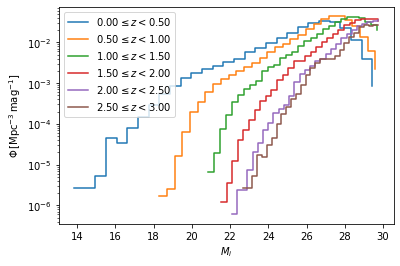

In [20]:
fig, ax = plt.subplots()
for z_min, z_max in z_slices:
    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask3 = np.logical_and(redshift3 >= z_min, redshift3 < z_max)
    magnitude_bin3 = magnitude3[z_mask3]
    bins3 = np.linspace(min(magnitude_bin3), max(magnitude_bin3), 30)
    dV_dz3 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
    dV3 = np.trapz(dV_dz3, z)
    dM3 = (np.max(bins3) - np.min(bins3)) / (np.size(bins3) - 1)
    phi_dc2 = np.histogram(magnitude3[z_mask3], bins=bins3)[0] / dV3 / dM3

    # Plotting
    ax.step(
        bins3[:-1],
        phi_dc2,
        where="post",
        label=r"${:.2f} \leq z < {:.2f}$".format(z_min, z_max),
        zorder=3,
    )
    ax.set_xlabel(r"$M_i$")
    ax.set_ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$")
    ax.set_yscale("log")
    # ax.set_xlim([-14, -24])
    # ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="upper left")
plt.show()

In [20]:
path = os.getcwd()
new_path = path.replace("notebooks/validation_notebooks", 'tests/TestData/') 

In [21]:
new_path

'/Users/narayankhadka/slsim/tests/TestData/'